<a href="https://colab.research.google.com/github/YC0429/Enefit---Predict-Energy-Behavior-of-Prosumers/blob/main/Enefit_Time_Series_Analysis_workplace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workplace for Enefit - Predict Energy Behavior of Prosumers**
https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/overview


## Import necessary libraries

In [1]:
import os, glob
import json
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data sets

In [3]:
path = "drive/MyDrive/Colab Notebooks/Kaggle Related/Enefit - Predict Energy Behavior of Prosumers/data/data_source/"

### Weather forecasts that would have been available at prediction time.

In [4]:
forecast_weather_df  = pd.read_csv(path+"forecast_weather.csv")
forecast_weather_df['origin_datetime'] = pd.to_datetime(forecast_weather_df['origin_datetime'])
forecast_weather_df['forecast_datetime'] = pd.to_datetime(forecast_weather_df['forecast_datetime'])

forecast_weather_df.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [ ]:
forecast_weather_df.isnull().sum()

latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
data_block_id                        0
forecast_datetime                    0
direct_solar_radiation               0
surface_solar_radiation_downwards    2
snowfall                             0
total_precipitation                  0
dtype: int64

### Historic weather data.

In [5]:
historical_weather_df = pd.read_csv(path+"historical_weather.csv")
historical_weather_df['datetime'] = pd.to_datetime(historical_weather_df['datetime'])

historical_weather_df.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [ ]:
historical_weather_df.isnull().sum()

datetime                  0
temperature               0
dewpoint                  0
rain                      0
snowfall                  0
surface_pressure          0
cloudcover_total          0
cloudcover_low            0
cloudcover_mid            0
cloudcover_high           0
windspeed_10m             0
winddirection_10m         0
shortwave_radiation       0
direct_solar_radiation    0
diffuse_radiation         0
latitude                  0
longitude                 0
data_block_id             0
dtype: int64

### Remaining data

In [6]:
train_df = pd.read_csv(path+'train.csv')
gas_prices_df = pd.read_csv(path+'gas_prices.csv')
client_df = pd.read_csv(path+'client.csv')
electricity_prices_df = pd.read_csv(path+'electricity_prices.csv')

In [7]:
print("Train Data:")
print(train_df.info())

print("\nGas Prices Data:")
print(gas_prices_df.info())

print("\nClient Data:")
print(client_df.info())

print("\nElectricity Prices Data:")
print(electricity_prices_df.info())

print("\nForecast Weather Data:")
print(forecast_weather_df.info())

print("\nHistorical Weather Data:")
print(historical_weather_df.info())

Train Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB
None

Gas Prices Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_

In [ ]:
print("Train Data:")
print(train_df.isnull().sum())

print("\nGas Prices Data:")
print(gas_prices_df.isnull().sum())

print("\nClient Data:")
print(client_df.isnull().sum())

print("\nElectricity Prices Data:")
print(electricity_prices_df.isnull().sum())

print("\nForecast Weather Data:")
print(forecast_weather_df.isnull().sum())

print("\nHistorical Weather Data:")
print(historical_weather_df.isnull().sum())

Train Data:
county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

Gas Prices Data:
forecast_date            0
lowest_price_per_mwh     0
highest_price_per_mwh    0
origin_date              0
data_block_id            0
dtype: int64

Client Data:
product_type          0
county                0
eic_count             0
installed_capacity    0
is_business           0
date                  0
data_block_id         0
dtype: int64

Electricity Prices Data:
forecast_date    0
euros_per_mwh    0
origin_date      0
data_block_id    0
dtype: int64

Forecast Weather Data:
latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudco

In [ ]:
train_df.describe()

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.018352e+06,2.017824e+06,2018352.0,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,5.368261e-01,1.898927e+00,2.748556e+02,0.5,3.218746e+02,1.009176e+06,3.304538e+01
std,4.780990e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,1.826343e+02,5.826482e+05,1.959059e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,6.370000e+02,2.018351e+06,6.800000e+01


In [ ]:
train_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [ ]:
gas_prices_df.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [ ]:
electricity_prices_df.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [ ]:
client_df.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id,log_installed_capacity
0,1,0,108,952.89,0,2021-09-01,2,6.859499
1,2,0,17,166.40,0,2021-09-01,2,5.114395
2,3,0,688,7207.88,0,2021-09-01,2,8.882930
3,0,0,5,400.00,1,2021-09-01,2,5.991465
4,1,0,43,1411.00,1,2021-09-01,2,7.252054


## EDA part

In [ ]:
plt.style.use('fivethirtyeight')

### Prosumer Distribution by County

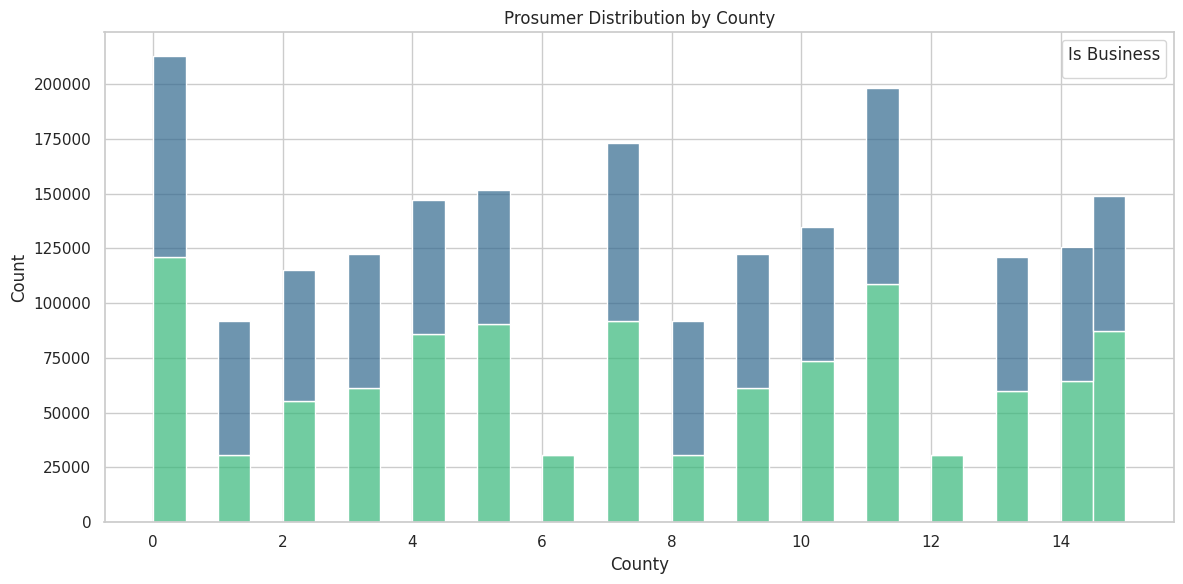

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(
    data=train_df,      # DataFrame containing the data
    x='county',        # Column to be plotted on the x-axis
    hue='is_business',    # Column to determine the color of the bars
    multiple='stack',     # Stacking bars for different categories
    bins=30,         # Number of bins (bars) in the histogram
    palette='viridis',    # Color palette
    alpha=0.7         # Transparency level of the bars
)

plt.xlabel('County')
plt.ylabel('Count')
plt.title('Prosumer Distribution by County')

plt.legend(title='Is Business', loc='upper right')

plt.tight_layout()
plt.show()

### Energy Consumption vs. Production

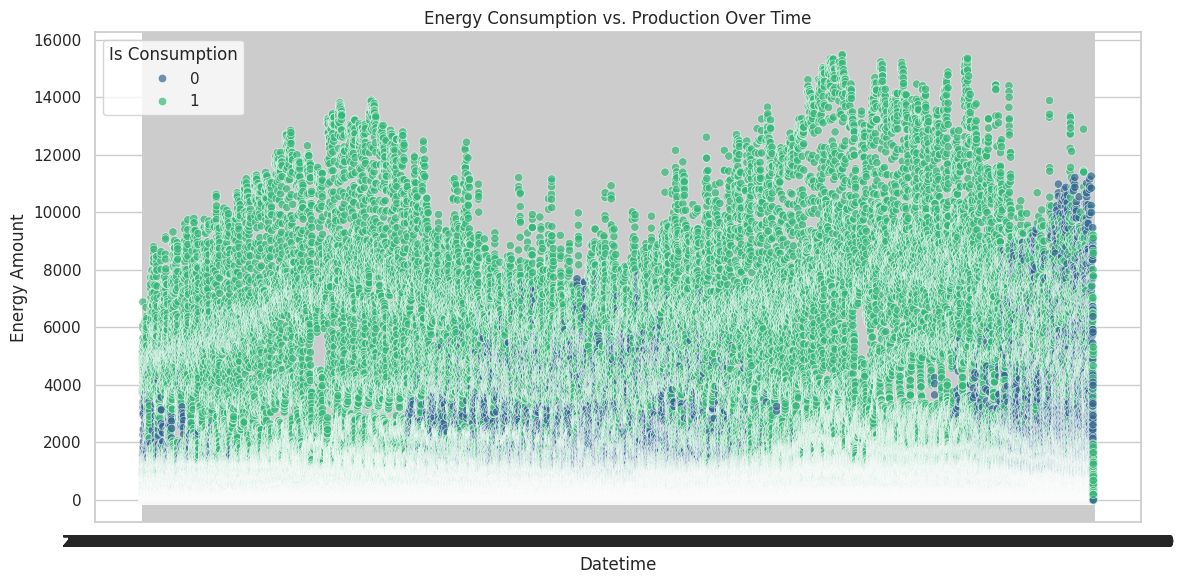

In [ ]:
plt.figure(figsize=(12, 6))
energy_consumption_production = sns.scatterplot(
    data=train_df,
    x='datetime',
    y='target',
    hue='is_consumption',
    palette='viridis',  # Choose a color palette
    alpha=0.7
)

# Set the title and labels
energy_consumption_production.set_title('Energy Consumption vs. Production Over Time')
energy_consumption_production.set_xlabel('Datetime')
energy_consumption_production.set_ylabel('Energy Amount')

# Show the legend
energy_consumption_production.legend(title='Is Consumption')

# Show the plot
plt.tight_layout()
plt.show()

### Gas price overtime

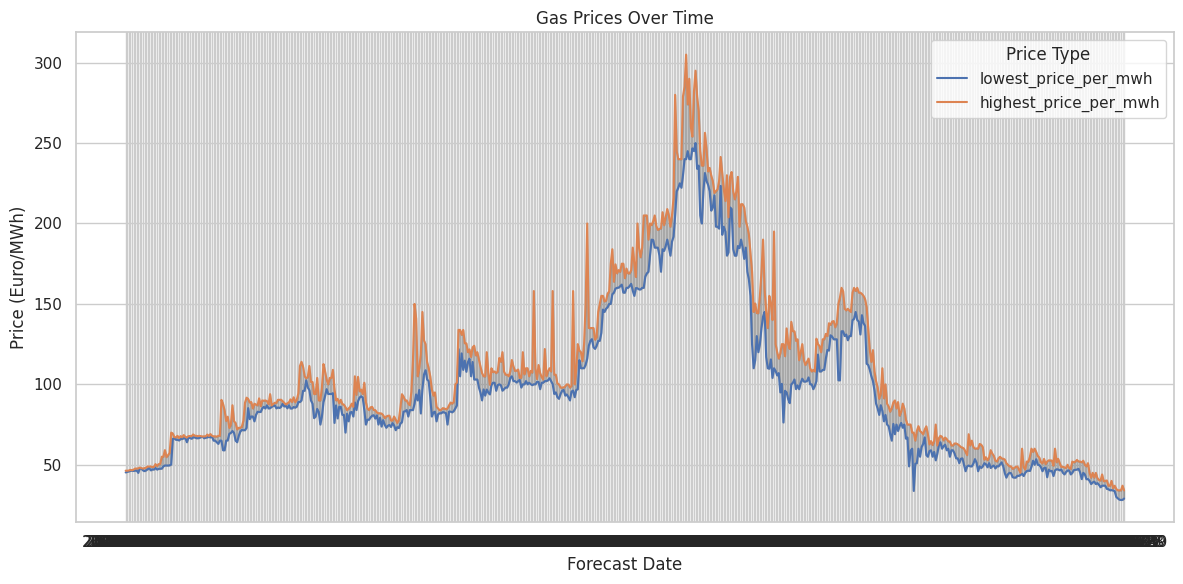

In [ ]:
# Melt the DataFrame into long format
# Use pd.melt to transform the DataFrame from wide to long format.
gas_prices_long = pd.melt(gas_prices_df, id_vars=['forecast_date'], value_vars=['lowest_price_per_mwh', 'highest_price_per_mwh'],
                          var_name='Price Type', value_name='Price (Euro/MWh)')

# Create the line plot
plt.figure(figsize=(12, 6))
gas_prices_over_time = sns.lineplot(
    data=gas_prices_long,
    x='forecast_date',
    y='Price (Euro/MWh)',
    hue='Price Type'
)

# Shade the area between the two lines
plt.fill_between(gas_prices_df['forecast_date'],
                 gas_prices_df['lowest_price_per_mwh'],
                 gas_prices_df['highest_price_per_mwh'],
                 color='k',
                 alpha=.2)

# Set the title and labels
plt.title('Gas Prices Over Time')
plt.xlabel('Forecast Date')
plt.ylabel('Price (Euro/MWh)')

# Show the plot
plt.tight_layout()
plt.show()

### Installed Capacity Distribution by Product Type

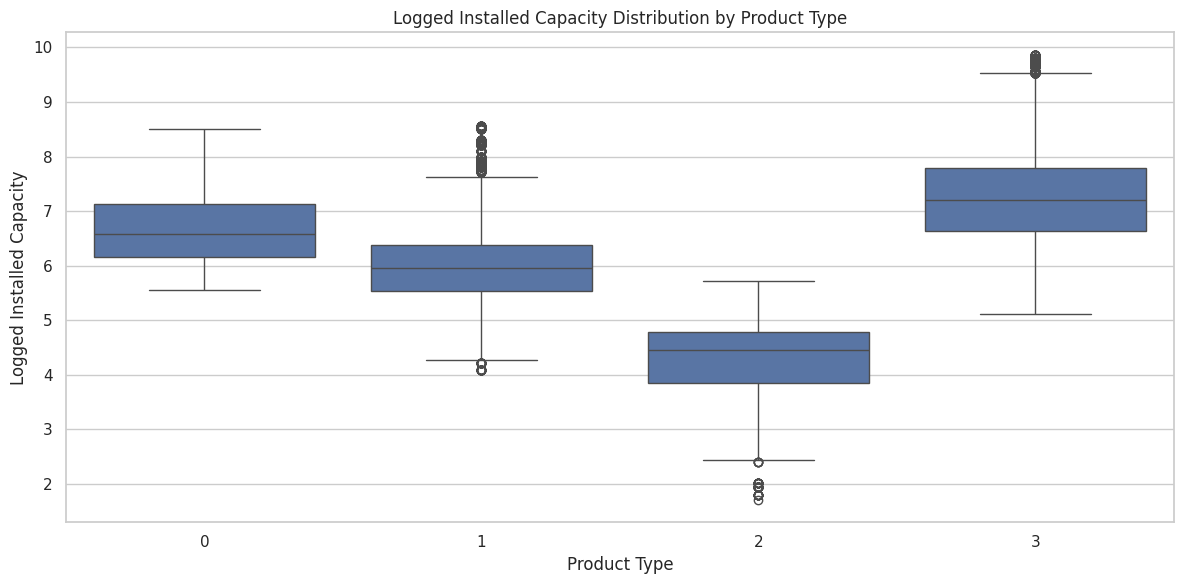

In [ ]:
# Calculate the 95th percentile of installed capacity, due to the volume of observations falls out of 1.5IQR + third quantile of the boxplot
# Making the boxplot to be squeezed
# percentile_95 = client_df['installed_capacity'].quantile(0.95)

# Apply log transformation to installed capacity, due to the volume of observations falls out of 1.5IQR + third quantile of the boxplot
# Making the boxplot to be squeezed
client_df['log_installed_capacity'] = np.log(client_df['installed_capacity'])

plt.figure(figsize=(12, 6))
installed_capacity_distribution = sns.boxplot(client_df,
                        x='product_type',
                        y='log_installed_capacity',)
                        # whis=percentile_95)  # Adjust whiskers to the 95th percentile

# Set title and labels
installed_capacity_distribution.set_title('Logged Installed Capacity Distribution by Product Type')
installed_capacity_distribution.set_xlabel('Product Type')
installed_capacity_distribution.set_ylabel('Logged Installed Capacity')

# Show plot
plt.tight_layout()
plt.show()

### Electricity Price Distribution

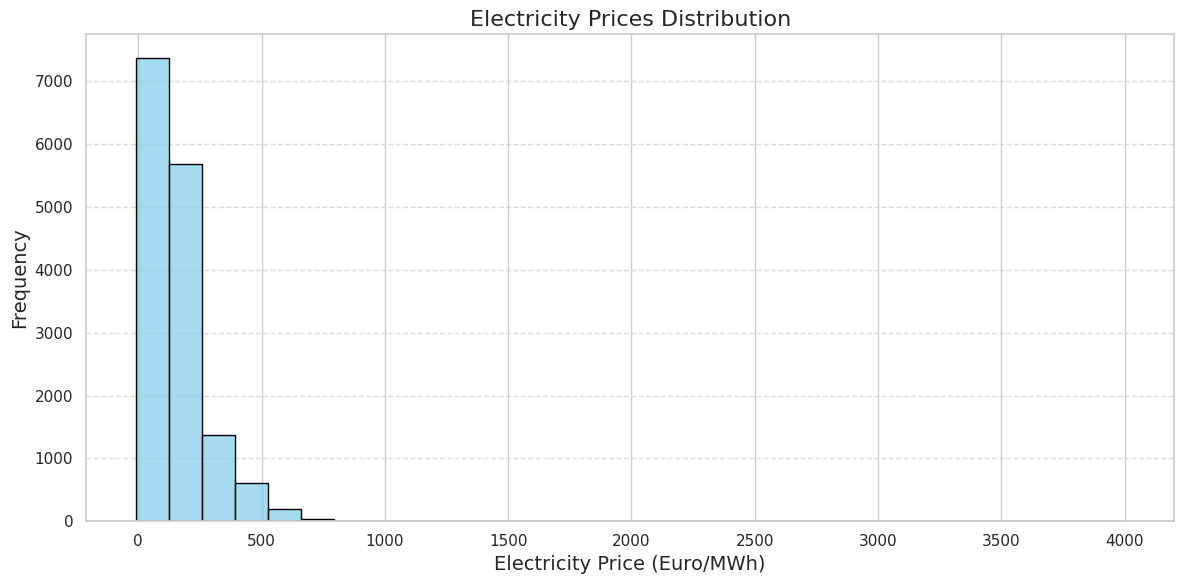

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
elec_price_distribution = sns.histplot(electricity_prices_df['euros_per_mwh'],
                     bins=30,
                     kde=False,
                     color='skyblue',
                     edgecolor='black')

elec_price_distribution.set_title('Electricity Prices Distribution', fontsize=16)
elec_price_distribution.set_xlabel('Electricity Price (Euro/MWh)', fontsize=14)
elec_price_distribution.set_ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Wind Speed Distribution

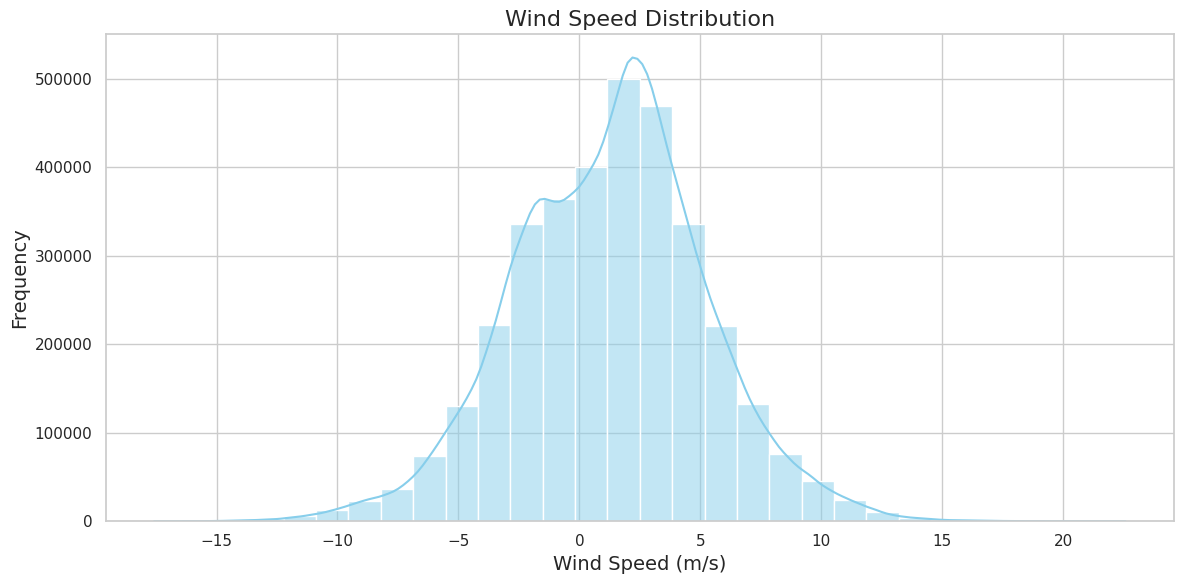

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
wind_spd_distribution = sns.histplot(forecast_weather_df['10_metre_u_wind_component'],
                    bins=30,
                    kde=True,
                    color='skyblue')

wind_spd_distribution.set_title('Wind Speed Distribution', fontsize=16)
wind_spd_distribution.set_xlabel('Wind Speed (m/s)', fontsize=14)
wind_spd_distribution.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

### Historical Rainfall Over Time

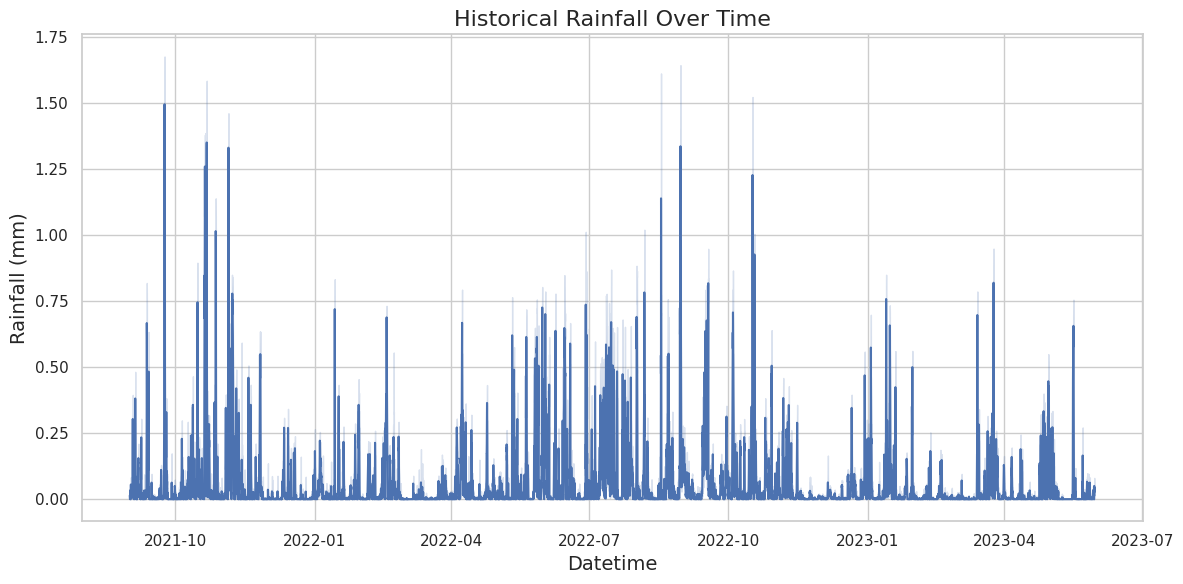

In [ ]:
# Create the line plot
plt.figure(figsize=(12, 6))
historical_rainfall_over_time = sns.lineplot(
    data=historical_weather_df,
    x='datetime',
    y='rain',
)


historical_rainfall_over_time.set_title('Historical Rainfall Over Time', fontsize=16)
historical_rainfall_over_time.set_xlabel('Datetime', fontsize=14)
historical_rainfall_over_time.set_ylabel('Rainfall (mm)', fontsize=14)

plt.tight_layout()
plt.show()

### Prosumer Type Pie Chart

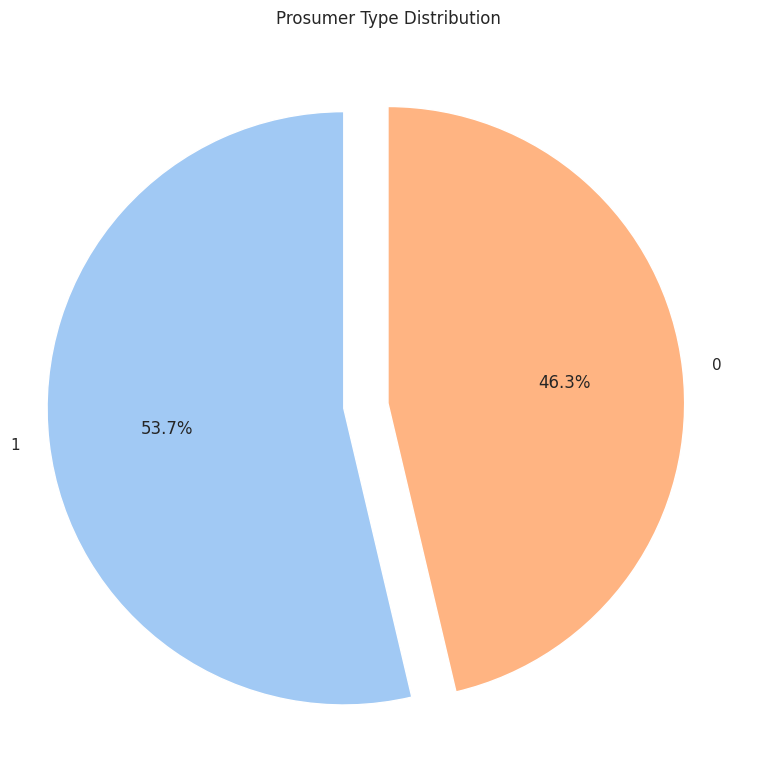

In [ ]:
prosumer_type_counts = train_df['is_business'].value_counts()

# Define the explode parameter (e.g., pop out the first slice)
explode = [0.15 if i == 0 else 0 for i in range(len(prosumer_type_counts))]

plt.figure(figsize=(8, 8))
sns.set_palette("pastel")
plt.pie(prosumer_type_counts,
    labels=prosumer_type_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    explode = explode, # with one slide exploded out
    # wedgeprops=dict(width=0.4) #This specifies that the width of each wedge should be 0.4 times the radius of the pie.
    )
plt.title('Prosumer Type Distribution')

plt.tight_layout()
plt.show()

### Correlation Heatmap

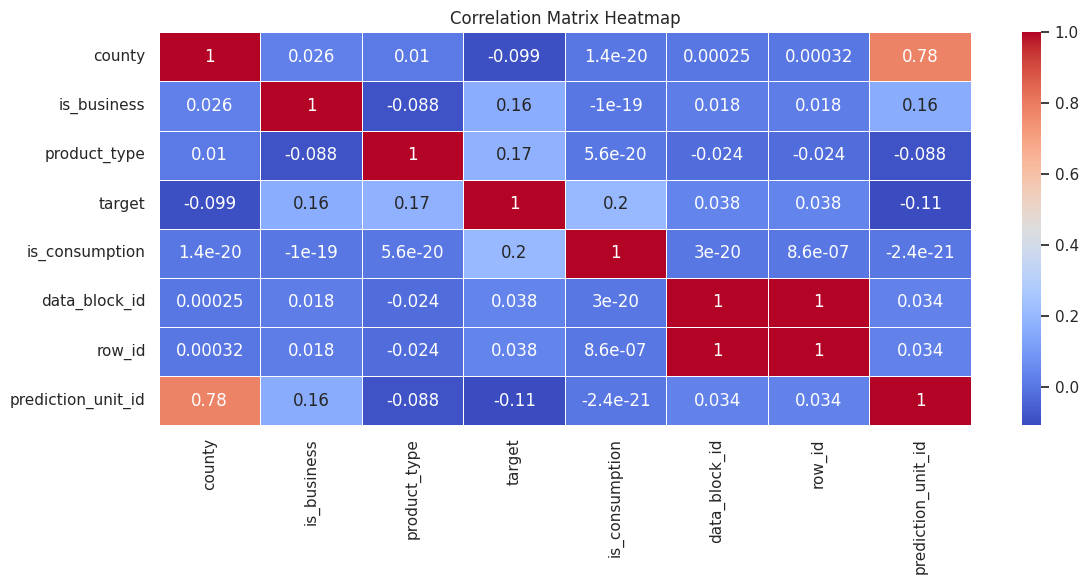

In [ ]:
cols = [c for c in train_df.columns if c not in ["datetime", "date"]]

corr_matrix = train_df[cols].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix,
      annot=True,
      cmap='coolwarm',
      linewidths=0.5)

# Set the title
plt.title('Correlation Matrix Heatmap')

# Display the plot
plt.tight_layout()
plt.show()

### Gas Prices vs. Electricity Prices Over Time

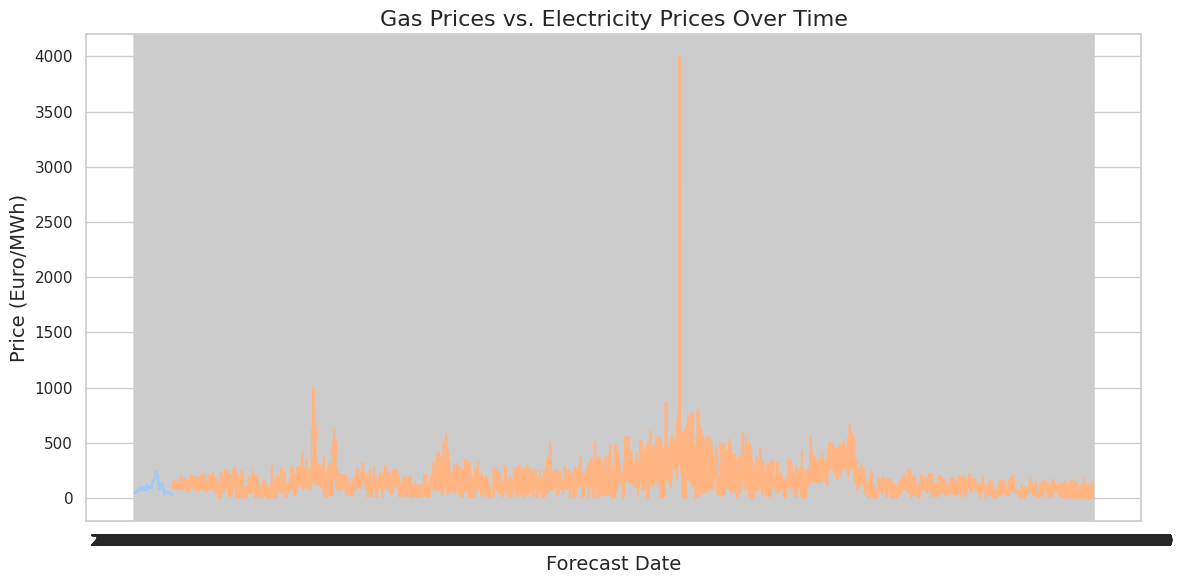

In [ ]:
# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=gas_prices_df,
    x='forecast_date',
    y='lowest_price_per_mwh',
)
sns.lineplot(
    data=electricity_prices_df,
    x='forecast_date',
    y='euros_per_mwh',
)

plt.title('Gas Prices vs. Electricity Prices Over Time', fontsize=16)
plt.xlabel('Forecast Date', fontsize=14)
plt.ylabel('Price (Euro/MWh)', fontsize=14)

plt.tight_layout()
plt.show()

## Time Series Analysis

### Energy Consumption Over Time

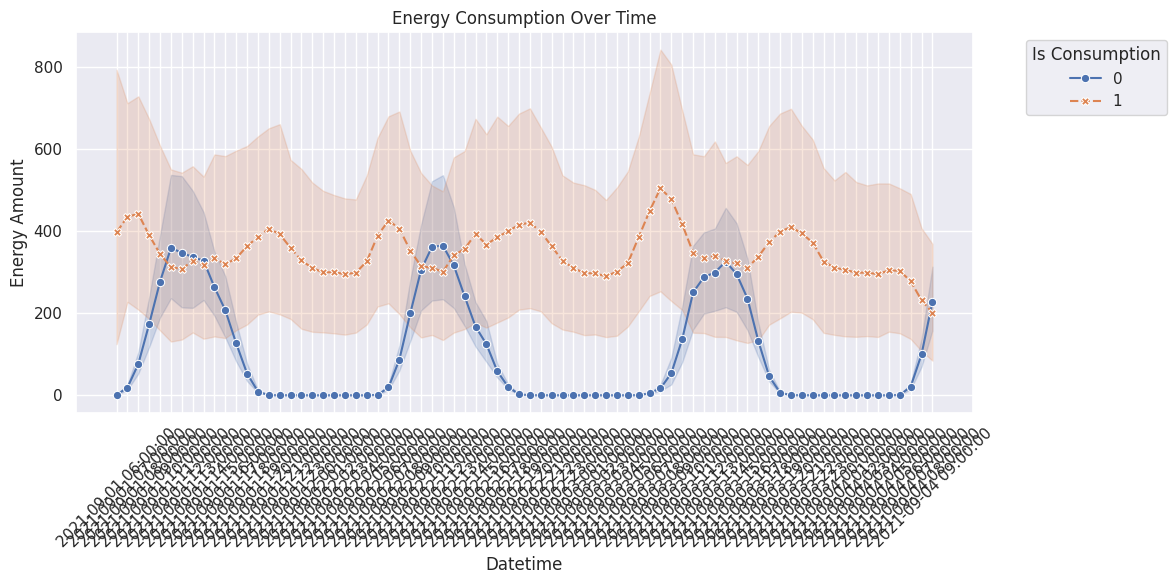

In [ ]:
subset_train_df = train_df[800:10000]

sns.set_theme()

plt.figure(figsize=(12, 6))
energy_consump_over_time = sns.lineplot(data=subset_train_df,
      x='datetime',
      y='target',
      hue='is_consumption',
      style='is_consumption',
      markers=True  # adds markers to the line plot
      )


energy_consump_over_time.set_xlabel('Datetime')
energy_consump_over_time.set_ylabel('Energy Amount')
energy_consump_over_time.set_title('Energy Consumption Over Time')

plt.legend(title='Is Consumption',
      bbox_to_anchor=(1.05, 1), # specify the location of the bounding box (bbox) for the legend
      loc='upper left')


# Rotating x-tick labels
plt.xticks(rotation=45)  # Rotate x-tick labels by 45 degrees

plt.tight_layout()
plt.show()

### Electricity Prices Over Time

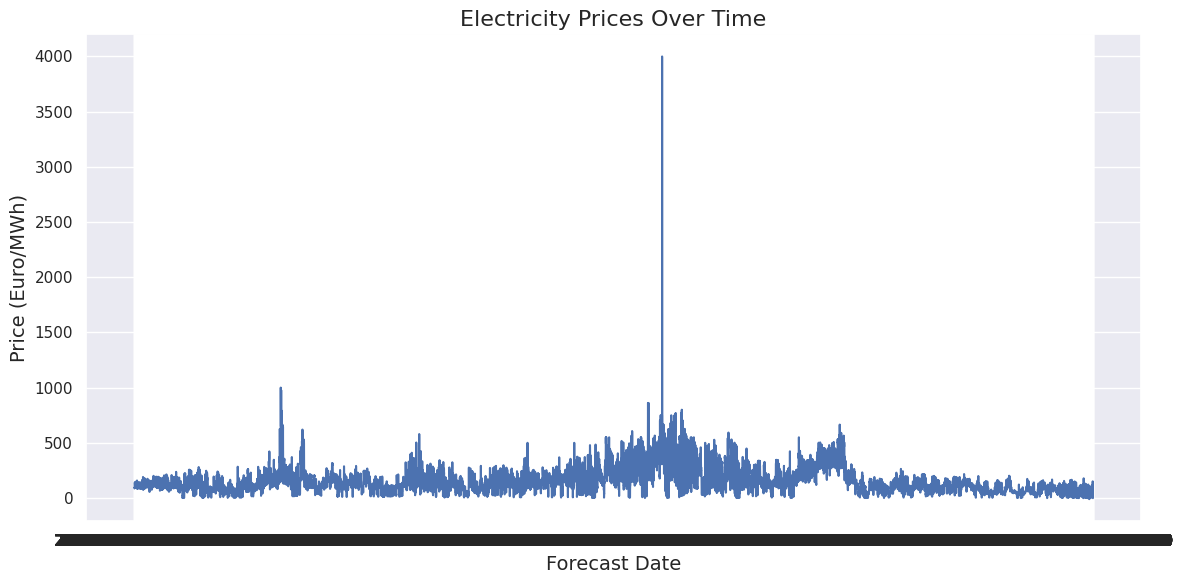

In [ ]:
# Create the line plot
plt.figure(figsize=(12, 6))
electricity_prices_over_time = sns.lineplot(
    data=electricity_prices_df,
    x='forecast_date',
    y='euros_per_mwh',
)

electricity_prices_over_time.set_title('Electricity Prices Over Time', fontsize=16)
electricity_prices_over_time.set_xlabel('Forecast Date', fontsize=14)
electricity_prices_over_time.set_ylabel('Price (Euro/MWh)', fontsize=14)

plt.tight_layout()
plt.show()

### Historical Rainfall Over Time (Refer to previous cells)

### Temperature vs. Dewpoint Over Time

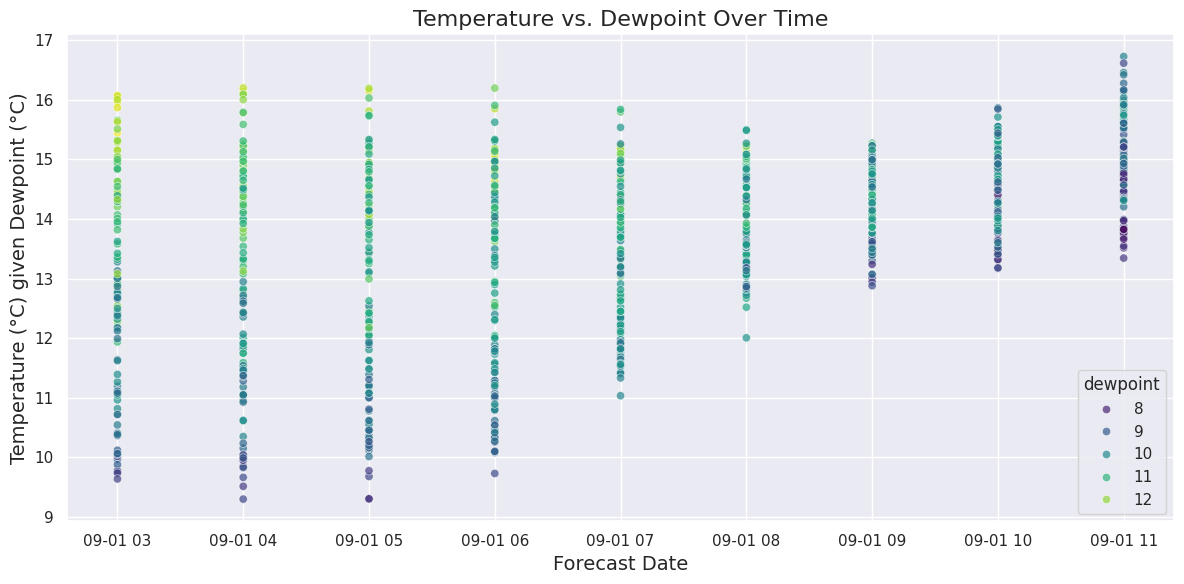

In [ ]:
# temp_dewpoint_comparison = px.scatter(forecast_weather_df[:1000], x='forecast_datetime', y='temperature',
#                                       color='dewpoint', title='Temperature vs. Dewpoint Over Time',
#                                       labels={'forecast_datetime': 'Forecast Datetime', 'temperature': 'Temperature (°C)', 'dewpoint': 'Dewpoint (°C)'})
# temp_dewpoint_comparison.show()

plt.figure(figsize=(12, 6))
temp_dewpoint_comparison = sns.scatterplot(
    data=forecast_weather_df[:1000],
    x='forecast_datetime',
    y='temperature',
    hue='dewpoint',
    palette='viridis',  # Choose a color palette
    alpha=0.7
)

temp_dewpoint_comparison.set_title('Temperature vs. Dewpoint Over Time', fontsize=16)
temp_dewpoint_comparison.set_xlabel('Forecast Date', fontsize=14)
temp_dewpoint_comparison.set_ylabel('Temperature (°C) given Dewpoint (°C)', fontsize=14)

plt.legend(title='dewpoint',
      loc='best')
plt.tight_layout()
plt.show()

### Wind Speed vs. Solar Radiation Over Time

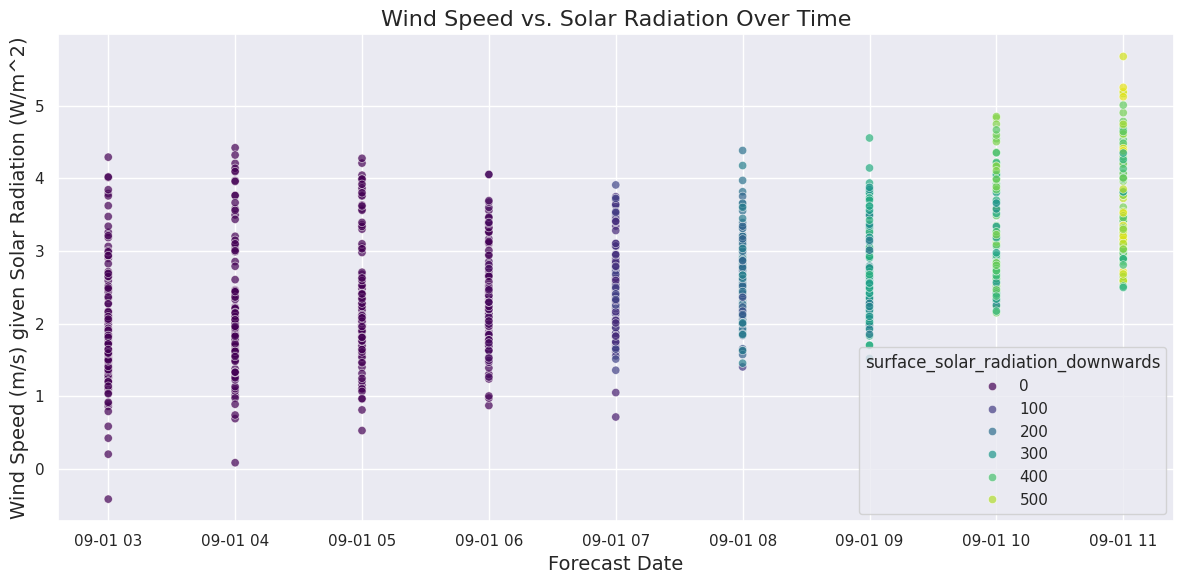

In [ ]:
# wind_speed_solar_radiation = px.scatter(forecast_weather_df[:1000], x='forecast_datetime', y='10_metre_u_wind_component',
#                                         color='surface_solar_radiation_downwards',
#                                         title='Wind Speed vs. Solar Radiation Over Time',
#                                         labels={'forecast_datetime': 'Forecast Datetime', '10_metre_u_wind_component': 'Wind Speed (m/s)', 'surface_solar_radiation_downwards': 'Solar Radiation (W/m^2)'})
# wind_speed_solar_radiation.show()

plt.figure(figsize=(12, 6))
wind_speed_solar_radiation = sns.scatterplot(
    data=forecast_weather_df[:1000],
    x='forecast_datetime',
    y='10_metre_u_wind_component',
    hue='surface_solar_radiation_downwards',
    palette='viridis',  # Choose a color palette
    alpha=0.7
)

wind_speed_solar_radiation.set_title('Wind Speed vs. Solar Radiation Over Time', fontsize=16)
wind_speed_solar_radiation.set_xlabel('Forecast Date', fontsize=14)
wind_speed_solar_radiation.set_ylabel('Wind Speed (m/s) given Solar Radiation (W/m^2)', fontsize=14)

plt.legend(title='surface_solar_radiation_downwards',
      loc='best')
plt.tight_layout()
plt.show()

# TSA: SARIMAX

In [8]:
!pip install pmdarima
from pmdarima.arima import auto_arima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00


## ARIMA model as a benchmark

In [9]:
train_init = train_df.dropna()
train_init['datetime'] = pd.to_datetime(train_init['datetime'])
train_init['datetime'] = train_init['datetime'].dt.date
# train_arima = train_df.head(30000)

In [10]:
# Group by 'datetime' and 'is_consumption' and calculate the mean of 'target'
agg_target = train_init.groupby(['datetime', 'is_consumption'])['target'].mean().reset_index()

# Rename the aggregated column for clarity
agg_target.rename(columns={'target': 'agg_target'}, inplace=True)

# Merge the aggregated results back into the original DataFrame
train_init = train_init.merge(agg_target, on=['datetime', 'is_consumption'], how='left')

train_init.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,agg_target
0,0,0,1,0.713,0,2021-09-01,0,0,0,107.585650
1,0,0,1,96.590,1,2021-09-01,0,1,0,351.045052
2,0,0,2,0.000,0,2021-09-01,0,2,1,107.585650
3,0,0,2,17.314,1,2021-09-01,0,3,1,351.045052
4,0,0,3,2.904,0,2021-09-01,0,4,2,107.585650


In [11]:
train_init.set_index('datetime', inplace=True)
train_init = train_init[train_init["is_consumption"]==1][["agg_target"]].drop_duplicates()
train_init.head()

,agg_target
datetime,
2021-09-01,351.045052
2021-09-02,354.445564
2021-09-03,360.600936
2021-09-04,254.962020
2021-09-05,250.662279


In [12]:
y_arima = train_init['agg_target']

In [13]:
train_size = int(len(y_arima) * 0.8)
train_set, test_set = y_arima[:train_size], y_arima[train_size:]

### Seasonal Decomposition

#### Method 1

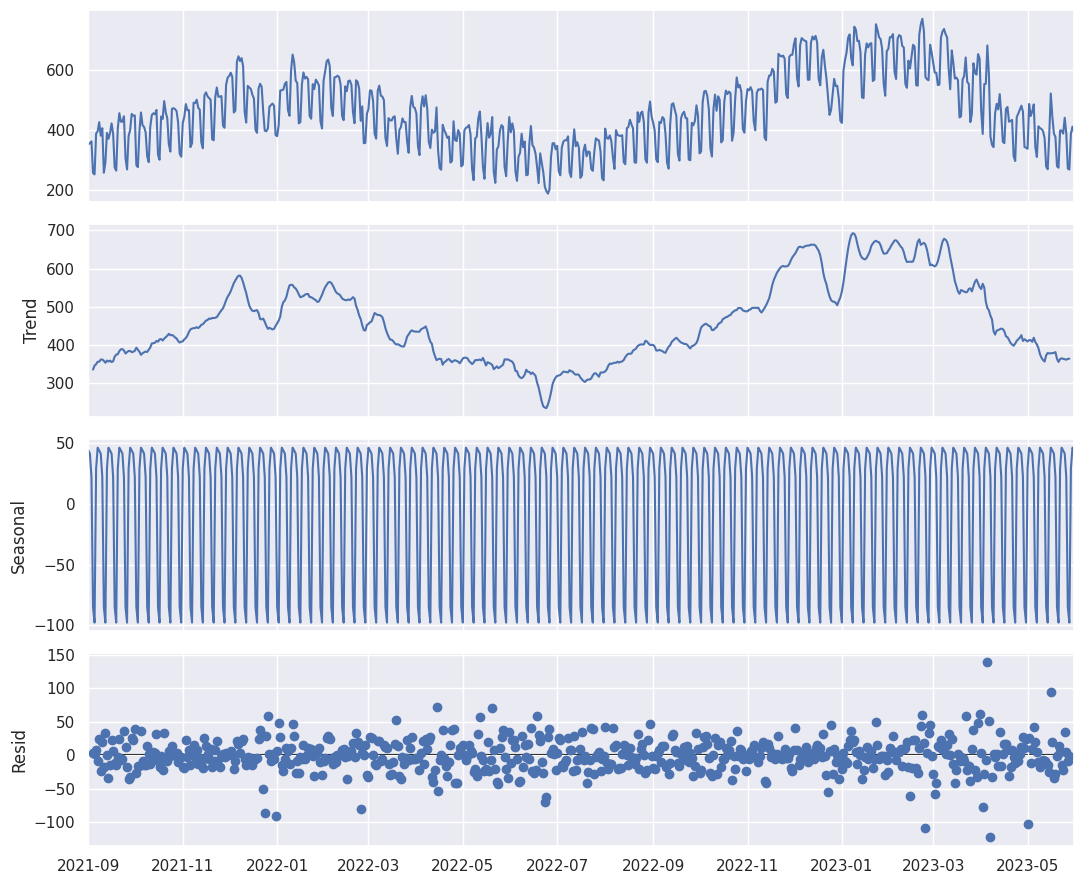

In [ ]:
rcParams['figure.figsize'] = 11, 9
# plt.figure(figsize=(11, 9))
# Perform seasonal decomposition with the specified frequency (annually)
pred_df_sim1_new = sm.tsa.seasonal_decompose(train_init,model='additive',period=7) #7 for daily data with weekly seasonality
pred_df_sim2_full = train_init['agg_target']
figure = pred_df_sim1_new.plot()
plt.show()

#### Method 2

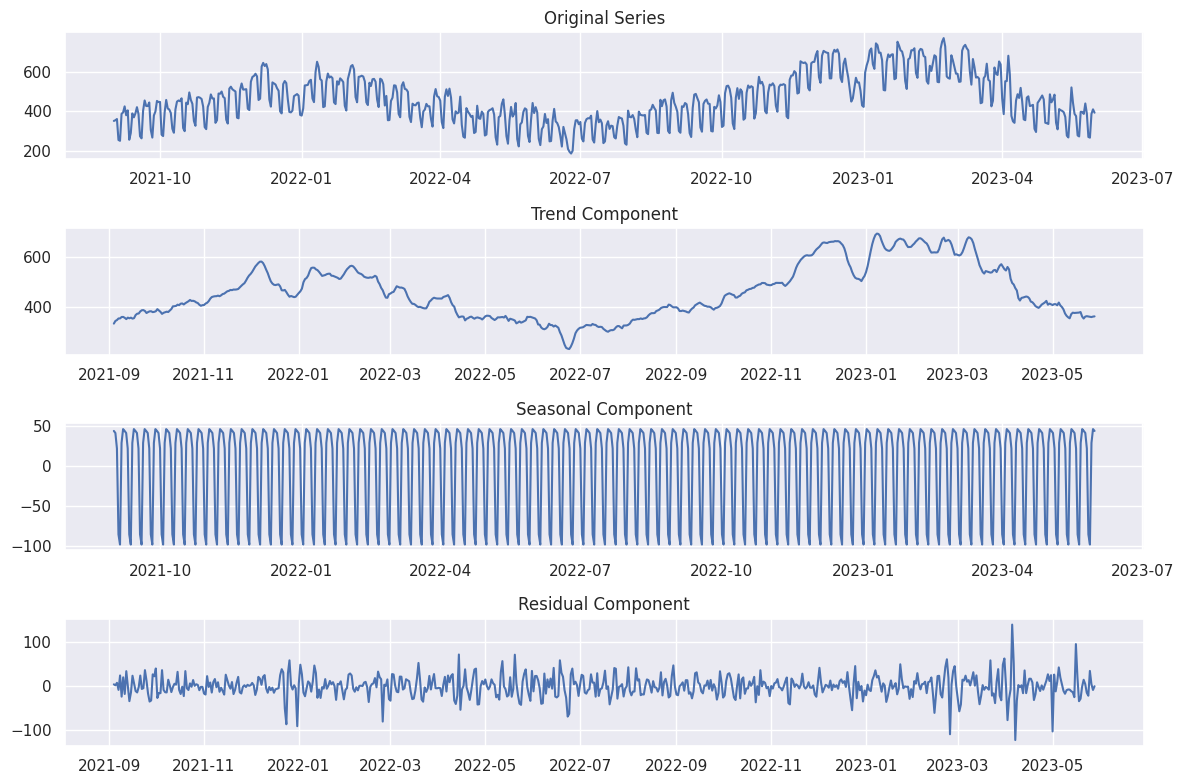

In [ ]:
result = sm.tsa.seasonal_decompose(train_init['agg_target'], model='additive', period=7)  # 7 for daily data with weekly seasonality
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(train_init, label='Original Series')
plt.title('Original Series')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

### ADF test

In [ ]:
result_adf = adfuller(residual)
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')
print('Critical Values:')
for key, value in result_adf[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -9.823287774955393
p-value: 5.2681877006416395e-17
Critical Values:
   1%: -3.4410979308822967
   5%: -2.8662819588823423
   10%: -2.5692953639629166


### ACF and PACF plot

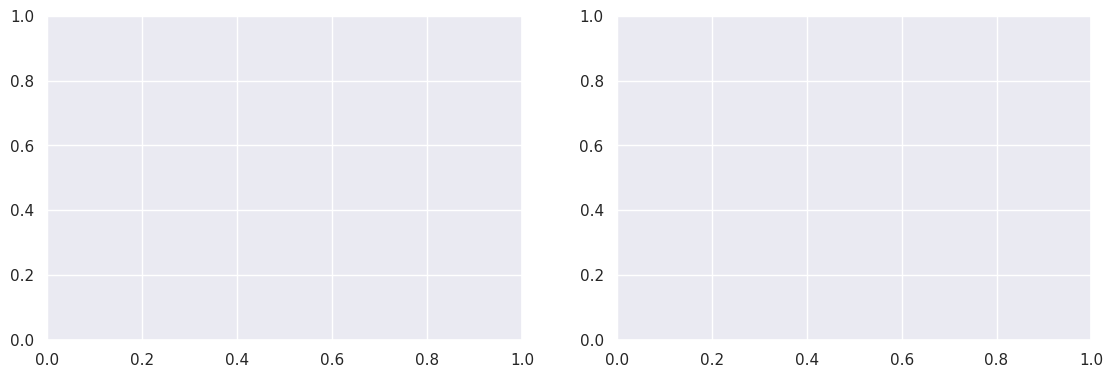

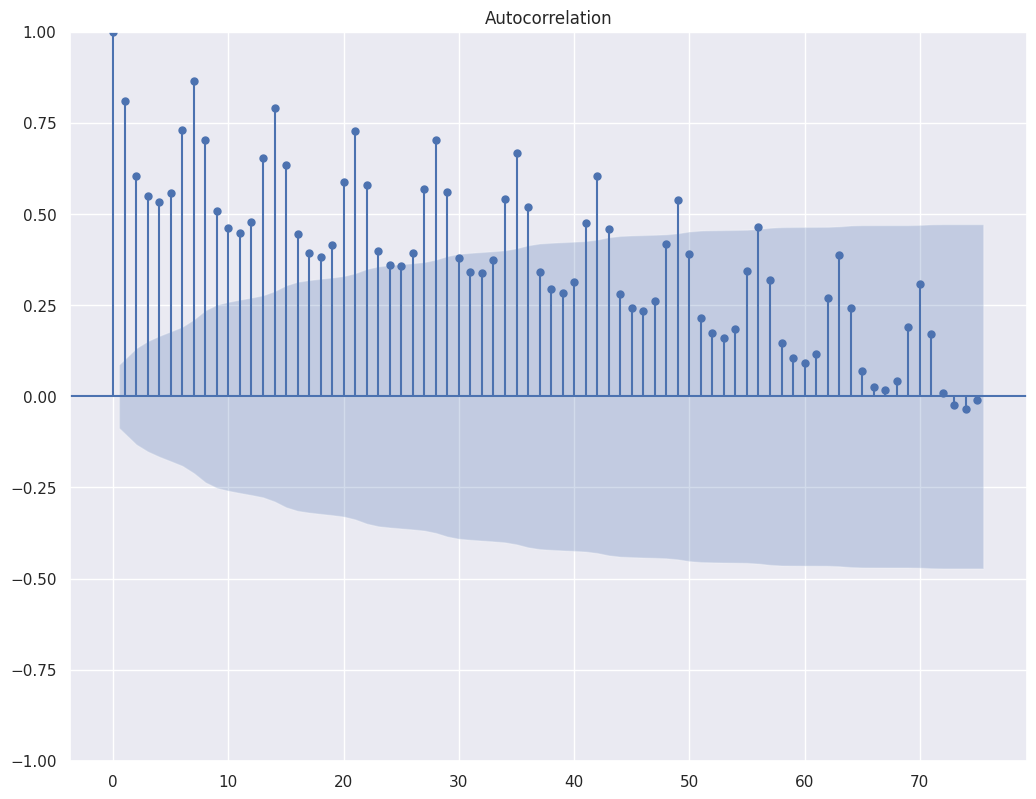

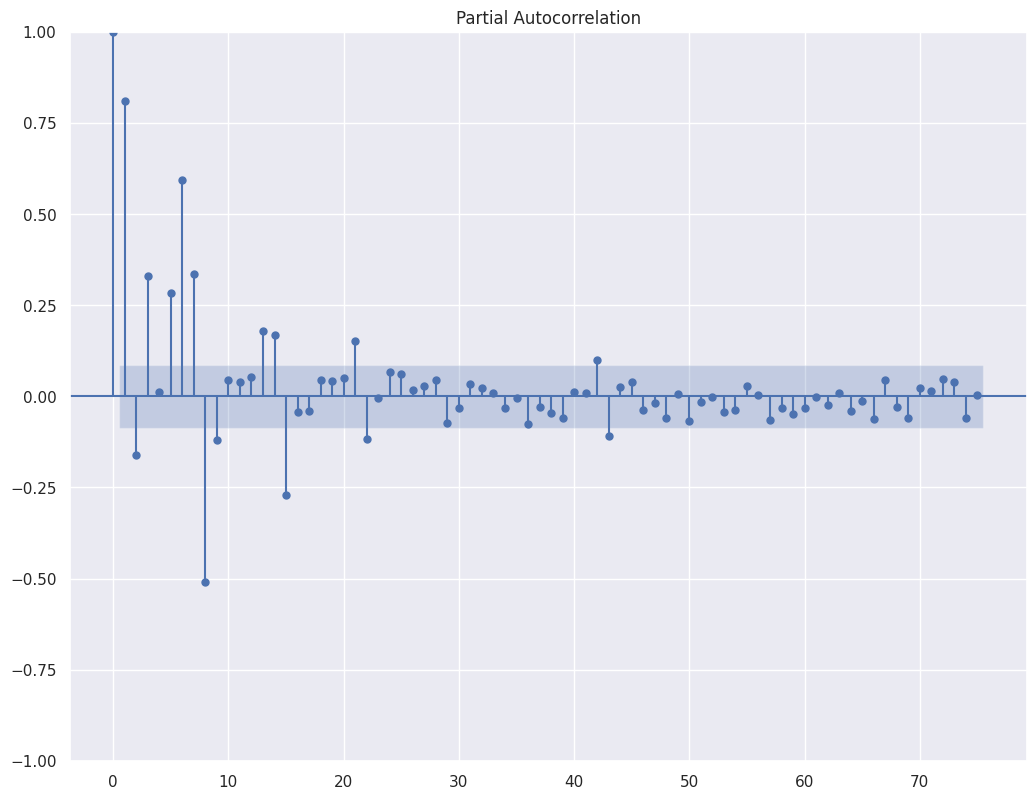

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_set, lags=75)
plot_pacf(train_set, lags=75)
plt.show()

### Auto SARIMA model

In [ ]:
auto_arima_model = auto_arima(train_set,
                seasonal=True,
                m=10,
                trace=True
                )
print(auto_arima_model)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[10] intercept   : AIC=inf, Time=3.04 sec
 ARIMA(0,1,0)(0,0,0)[10] intercept   : AIC=5775.835, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[10] intercept   : AIC=5771.286, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[10] intercept   : AIC=5765.398, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[10]             : AIC=5773.899, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[10] intercept   : AIC=5763.593, Time=0.11 sec
 ARIMA(0,1,1)(1,0,0)[10] intercept   : AIC=5765.409, Time=0.60 sec
 ARIMA(0,1,1)(1,0,1)[10] intercept   : AIC=5766.418, Time=1.22 sec
 ARIMA(1,1,1)(0,0,0)[10] intercept   : AIC=5733.476, Time=0.24 sec
 ARIMA(1,1,1)(1,0,0)[10] intercept   : AIC=5731.292, Time=0.94 sec
 ARIMA(1,1,1)(2,0,0)[10] intercept   : AIC=5650.412, Time=2.29 sec
 ARIMA(1,1,1)(2,0,1)[10] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(1,1,1)(1,0,1)[10] intercept   : AIC=5730.333, Time=0.83 sec
 ARIMA(0,1,1)(2,0,0)[10] intercept   : AIC=5767.152, Time=1.12 sec
 ARIMA(1,1,0)(2,0,0)[10] inte

In [ ]:
order = auto_arima_model.order
print("Order of the best SARIMA model:", order)
seasonal_order = auto_arima_model.seasonal_order
print("Seasonal order of the best SARIMA model:", seasonal_order)

Order of the best SARIMA model: (5, 1, 4)
Seasonal order of the best SARIMA model: (0, 0, 0, 10)


#### Check the prediction from the optimal SARIMA model

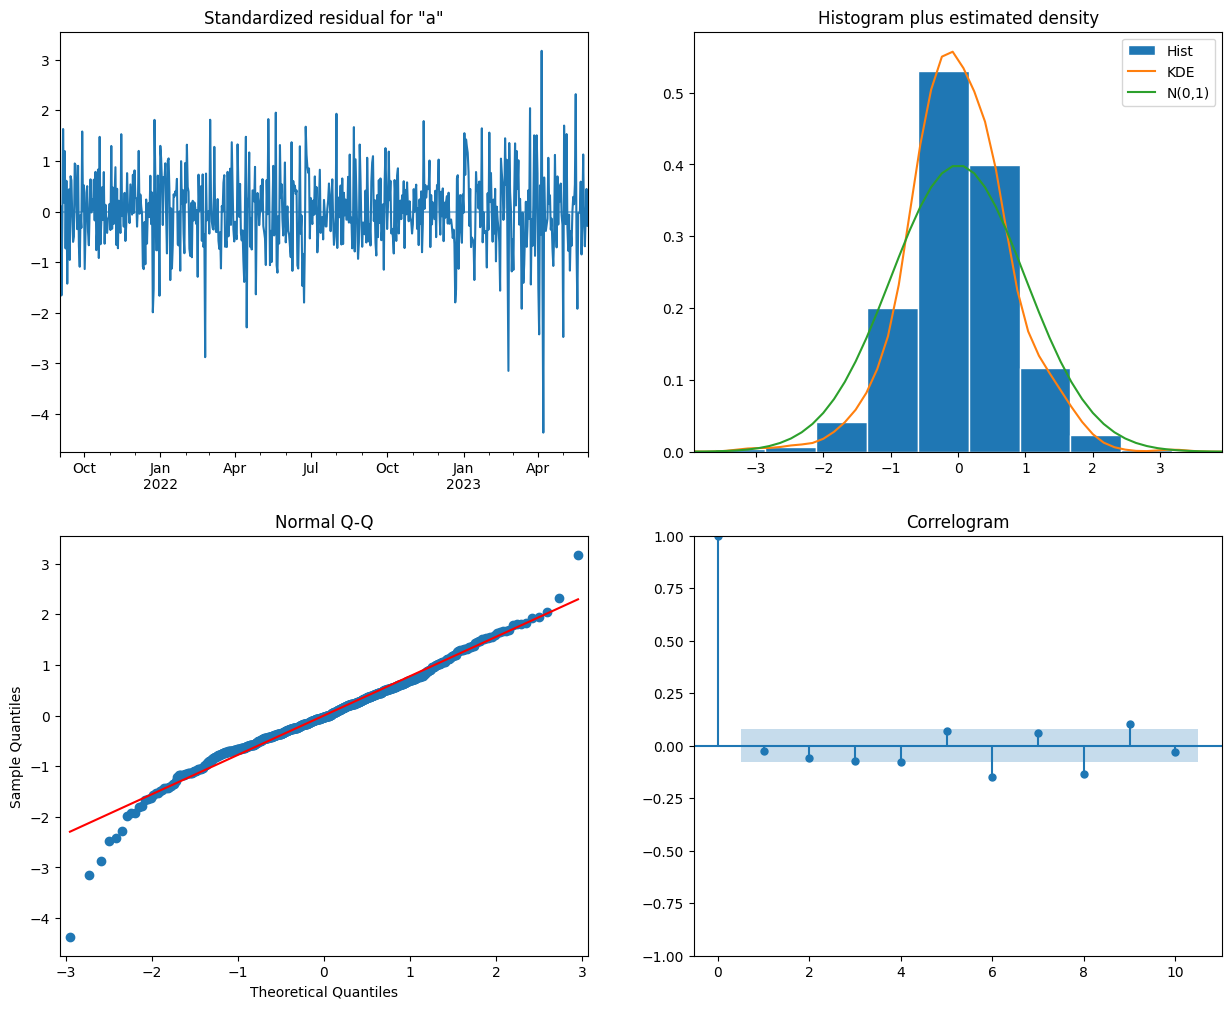

In [ ]:
# Get predictions from the SARIMAX model
best_mod = sm.tsa.statespace.SARIMAX(y_arima,order=(5,1,4),seasonal_order=(0, 0, 0, 10))

MSFTresults = best_mod.fit()

#print(TSresults.summary().tables[1])

MSFTresults.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
len(train_set)

510

In [ ]:
pred = MSFTresults.get_prediction(start=510, dynamic=False)

In [ ]:
pred.predicted_mean

2023-01-24    759.615927
2023-01-25    708.165859
2023-01-26    720.924062
2023-01-27    687.784706
2023-01-28    570.309880
                 ...    
2023-05-27    301.309196
2023-05-28    270.593317
2023-05-29    366.190886
2023-05-30    422.532854
2023-05-31    394.208423
Freq: D, Name: predicted_mean, Length: 128, dtype: float64

In [ ]:
mae = mean_absolute_error(test_set, pred.predicted_mean)
print(f"Mean Absolute Error (MAE): {mae}")
mape = mean_absolute_percentage_error(test_set, pred.predicted_mean)
print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")

Mean Absolute Error (MAE): 32.58972321911121
Mean Absolute Percentage Error (MAPE): 6.48%


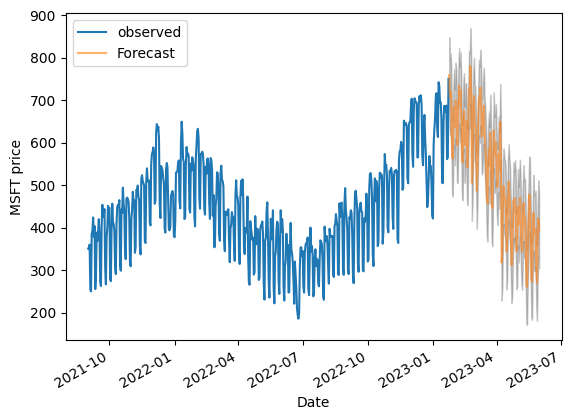

In [ ]:
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters.

ax = train_set.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('MSFT price')
plt.legend()

plt.show()

### Auto SARIMAX model

#### Data aggregation on the related datasets

In [14]:
electricity_prices_df.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [15]:
electricity_prices_df['forecast_date'] = pd.to_datetime(electricity_prices_df['forecast_date'])
electricity_prices_df['forecast_date'] = electricity_prices_df['forecast_date'].dt.date
# train_arima = train_df.head(30000)

In [16]:
# Group by 'datetime' and 'is_consumption' and calculate the mean of 'target'
agg_elec_price = electricity_prices_df.groupby(['forecast_date'])['euros_per_mwh'].mean().reset_index()

# Rename the aggregated column for clarity
agg_elec_price.rename(columns={'euros_per_mwh': 'agg_elec_price'}, inplace=True)

# Merge the aggregated results back into the original DataFrame
electricity_prices_df = electricity_prices_df.merge(agg_elec_price, on=['forecast_date'], how='left')

electricity_prices_df.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id,agg_elec_price
0,2021-09-01,92.51,2021-08-31 00:00:00,1,110.467083
1,2021-09-01,88.90,2021-08-31 01:00:00,1,110.467083
2,2021-09-01,87.35,2021-08-31 02:00:00,1,110.467083
3,2021-09-01,86.88,2021-08-31 03:00:00,1,110.467083
4,2021-09-01,88.43,2021-08-31 04:00:00,1,110.467083


In [23]:
electricity_prices_df = electricity_prices_df.set_index('forecast_date').rename_axis('datetime')
electricity_prices_df.head()

,euros_per_mwh,origin_date,data_block_id,agg_elec_price
datetime,,,,
2021-09-01,92.51,2021-08-31 00:00:00,1,110.467083
2021-09-01,88.90,2021-08-31 01:00:00,1,110.467083
2021-09-01,87.35,2021-08-31 02:00:00,1,110.467083
2021-09-01,86.88,2021-08-31 03:00:00,1,110.467083
2021-09-01,88.43,2021-08-31 04:00:00,1,110.467083


In [28]:
electricity_prices_df_updt = pd.DataFrame(electricity_prices_df['agg_elec_price'].drop_duplicates())

electricity_prices_df_updt.head()

,agg_elec_price
datetime,
2021-09-01,110.467083
2021-09-02,112.631250
2021-09-03,107.429583
2021-09-04,106.112917
2021-09-05,99.045417


In [22]:
gas_prices_df['avg_gas_price'] = (gas_prices_df['lowest_price_per_mwh'] + gas_prices_df['highest_price_per_mwh'])/2
gas_prices_df.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,avg_gas_price
0,2021-09-01,45.23,46.32,2021-08-31,1,45.775
1,2021-09-02,45.62,46.29,2021-09-01,2,45.955
2,2021-09-03,45.85,46.40,2021-09-02,3,46.125
3,2021-09-04,46.30,46.80,2021-09-03,4,46.550
4,2021-09-05,46.30,46.58,2021-09-04,5,46.440


In [24]:
gas_prices_df = gas_prices_df.set_index('forecast_date').rename_axis('datetime')
gas_prices_df.head()

,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,avg_gas_price
datetime,,,,,
2021-09-01,45.23,46.32,2021-08-31,1,45.775
2021-09-02,45.62,46.29,2021-09-01,2,45.955
2021-09-03,45.85,46.40,2021-09-02,3,46.125
2021-09-04,46.30,46.80,2021-09-03,4,46.550
2021-09-05,46.30,46.58,2021-09-04,5,46.440


In [47]:
gas_prices_df.index = pd.to_datetime(gas_prices_df.index)

In [37]:
electricity_prices_df_updt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 637 entries, 2021-09-01 to 2023-05-30
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   agg_elec_price  637 non-null    float64
dtypes: float64(1)
memory usage: 26.1+ KB


In [40]:
train_init.info()

<class 'pandas.core.frame.DataFrame'>
Index: 638 entries, 2021-09-01 to 2023-05-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   agg_target  638 non-null    float64
dtypes: float64(1)
memory usage: 26.1+ KB


In [51]:
train_new = train_init.merge(electricity_prices_df_updt, on=['datetime'], how='left')

train_new = train_new.join(gas_prices_df['avg_gas_price'], how='left')

train_new.head()

,agg_target,agg_elec_price,avg_gas_price
datetime,,,
2021-09-01,351.045052,110.467083,45.775
2021-09-02,354.445564,112.631250,45.955
2021-09-03,360.600936,107.429583,46.125
2021-09-04,254.962020,106.112917,46.550
2021-09-05,250.662279,99.045417,46.440


#### Create logged electricity price and gas price

In [52]:
train_new['logged_agg_elec_price'] = np.log(train_new['agg_elec_price'])

train_new['logged_avg_gas_price'] = np.log(train_new['avg_gas_price'])

train_new.head()

,agg_target,agg_elec_price,avg_gas_price,logged_agg_elec_price,logged_avg_gas_price
datetime,,,,,
2021-09-01,351.045052,110.467083,45.775,4.704718,3.823738
2021-09-02,354.445564,112.631250,45.955,4.724119,3.827663
2021-09-03,360.600936,107.429583,46.125,4.676836,3.831355
2021-09-04,254.962020,106.112917,46.550,4.664504,3.840527
2021-09-05,250.662279,99.045417,46.440,4.595578,3.838161


In [58]:
train_new['diff_agg_elec_price'] = train_new['agg_elec_price'].diff()

train_new['diff_avg_gas_price'] = train_new['avg_gas_price'].diff()

train_new.head()

,agg_target,agg_elec_price,avg_gas_price,logged_agg_elec_price,logged_avg_gas_price,diff_agg_elec_price,diff_avg_gas_price
datetime,,,,,,,
2021-09-01,351.045052,110.467083,45.775,4.704718,3.823738,NaN,NaN
2021-09-02,354.445564,112.631250,45.955,4.724119,3.827663,2.164167,0.180
2021-09-03,360.600936,107.429583,46.125,4.676836,3.831355,-5.201667,0.170
2021-09-04,254.962020,106.112917,46.550,4.664504,3.840527,-1.316667,0.425
2021-09-05,250.662279,99.045417,46.440,4.595578,3.838161,-7.067500,-0.110


In [61]:
train_new['diff2_agg_elec_price'] = train_new['agg_elec_price'].diff().diff()

train_new['diff2_avg_gas_price'] = train_new['avg_gas_price'].diff().diff()

train_new.head()

,agg_target,agg_elec_price,avg_gas_price,logged_agg_elec_price,logged_avg_gas_price,diff_agg_elec_price,diff_avg_gas_price,diff2_agg_elec_price,diff2_avg_gas_price
datetime,,,,,,,,,
2021-09-01,351.045052,110.467083,45.775,4.704718,3.823738,0.000000,0.000,NaN,NaN
2021-09-02,354.445564,112.631250,45.955,4.724119,3.827663,2.164167,0.180,NaN,NaN
2021-09-03,360.600936,107.429583,46.125,4.676836,3.831355,-5.201667,0.170,-7.365833,-0.010
2021-09-04,254.962020,106.112917,46.550,4.664504,3.840527,-1.316667,0.425,3.885000,0.255
2021-09-05,250.662279,99.045417,46.440,4.595578,3.838161,-7.067500,-0.110,-5.750833,-0.535


In [62]:
train_new['diff2_agg_elec_price'].fillna(0, inplace=True)
train_new['diff2_avg_gas_price'].fillna(0, inplace=True)

train_new.head()

,agg_target,agg_elec_price,avg_gas_price,logged_agg_elec_price,logged_avg_gas_price,diff_agg_elec_price,diff_avg_gas_price,diff2_agg_elec_price,diff2_avg_gas_price
datetime,,,,,,,,,
2021-09-01,351.045052,110.467083,45.775,4.704718,3.823738,0.000000,0.000,0.000000,0.000
2021-09-02,354.445564,112.631250,45.955,4.724119,3.827663,2.164167,0.180,0.000000,0.000
2021-09-03,360.600936,107.429583,46.125,4.676836,3.831355,-5.201667,0.170,-7.365833,-0.010
2021-09-04,254.962020,106.112917,46.550,4.664504,3.840527,-1.316667,0.425,3.885000,0.255
2021-09-05,250.662279,99.045417,46.440,4.595578,3.838161,-7.067500,-0.110,-5.750833,-0.535


#### ADF test to check whether each column is stationary

In [63]:
cols_to_ck = ['agg_elec_price', 'avg_gas_price', 'logged_agg_elec_price', 'logged_avg_gas_price', 'diff_agg_elec_price', 'diff_avg_gas_price', 'diff2_agg_elec_price', 'diff2_avg_gas_price']

for col in cols_to_ck:
  result_adf = adfuller(train_new[col])
  print(f'ADF Statistic of {col}: {result_adf[0]}')
  print(f'p-value of {col}: {result_adf[1]}')
  print('Critical Values of {col}:')
  for key, value in result_adf[4].items():
      print(f'   {key}: {value}')

ADF Statistic of agg_elec_price: -3.0156557334507013
p-value of agg_elec_price: 0.033457993208184246
Critical Values of {col}:
   1%: -3.440958441424668
   5%: -2.86622052433566
   10%: -2.569262629991048
ADF Statistic of avg_gas_price: -1.3933813789963914
p-value of avg_gas_price: 0.5854450232108109
Critical Values of {col}:
   1%: -3.4407890899441127
   5%: -2.8661459340578905
   10%: -2.5692228868342766
ADF Statistic of logged_agg_elec_price: -2.2193179752194094
p-value of logged_agg_elec_price: 0.1993090004850508
Critical Values of {col}:
   1%: -3.4409070618215996
   5%: -2.8661978948030686
   10%: -2.569250572471335
ADF Statistic of logged_avg_gas_price: -0.6678108290651907
p-value of logged_avg_gas_price: 0.8549120346604548
Critical Values of {col}:
   1%: -3.4406900498266193
   5%: -2.8661023102613137
   10%: -2.569199643499287
ADF Statistic of diff_agg_elec_price: -6.296023278456128
p-value of diff_agg_elec_price: 3.5043269608997606e-08
Critical Values of {col}:
   1%: -3.4409

#### Pearson Correlation Test, used to test the strength and direction of the linear relationship between two continuous variables.

In [64]:
from scipy.stats import pearsonr

correlation_elec_price, p_value = pearsonr(train_new['agg_elec_price'], train_new['agg_target'])
print(f"Pearson correlation coefficient of electricity price: {correlation_elec_price}, p-value: {p_value}")

Pearson correlation coefficient of electricity price: 0.08952000937917123, p-value: 0.023853341604132345


In [65]:
correlation_gas_price, p_value_gas = pearsonr(train_new['avg_gas_price'], train_new['agg_target'])
print(f"Pearson correlation coefficient of gas price: {correlation_gas_price}, p-value: {p_value_gas}")

Pearson correlation coefficient of gas price: -0.2322017044366713, p-value: 3.0249792308343714e-09


#### Fit the auto SARIMAX model

In [67]:
exog = train_new[['agg_elec_price','avg_gas_price']]

In [69]:
# Fit the auto ARIMAX model
auto_sarimax_model = auto_arima(
    train_new['agg_target'],
    exogenous=exog,
    seasonal=True,
    m=10,
    trace=True,
    error_action='ignore',  # To ignore non-fatal errors
    suppress_warnings=True,  # To suppress warnings
    stepwise=True,  # To perform stepwise search for faster computation
    trend='c'  # Include an intercept term
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[10] intercept   : AIC=6967.272, Time=2.27 sec
 ARIMA(0,1,0)(0,0,0)[10] intercept   : AIC=7239.699, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[10] intercept   : AIC=7232.420, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[10] intercept   : AIC=7229.429, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[10]             : AIC=7239.699, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[10] intercept   : AIC=6966.675, Time=1.24 sec
 ARIMA(2,1,2)(0,0,0)[10] intercept   : AIC=6912.230, Time=0.55 sec
 ARIMA(2,1,2)(1,0,0)[10] intercept   : AIC=6965.845, Time=1.59 sec
 ARIMA(1,1,2)(0,0,0)[10] intercept   : AIC=7002.745, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[10] intercept   : AIC=6986.267, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[10] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(2,1,3)(0,0,0)[10] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[10] intercept   : AIC=7190.805, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[10] intercept   : AIC=7002.106, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[10] inte

In [71]:
order = auto_sarimax_model.order
print("Order of the best SARIMAX model:", order)
seasonal_order = auto_sarimax_model.seasonal_order
print("Seasonal order of the best SARIMAX model:", seasonal_order)

Order of the best SARIMAX model: (2, 1, 3)
Seasonal order of the best SARIMAX model: (2, 0, 0, 10)


In [70]:
auto_sarimax_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 3),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 0, 0, 10),
 'start_params': None,
 'suppress_warnings': True,
 'trend': 'c',
 'with_intercept': False}

#### Check the prediction of the optimal SARIMAX model

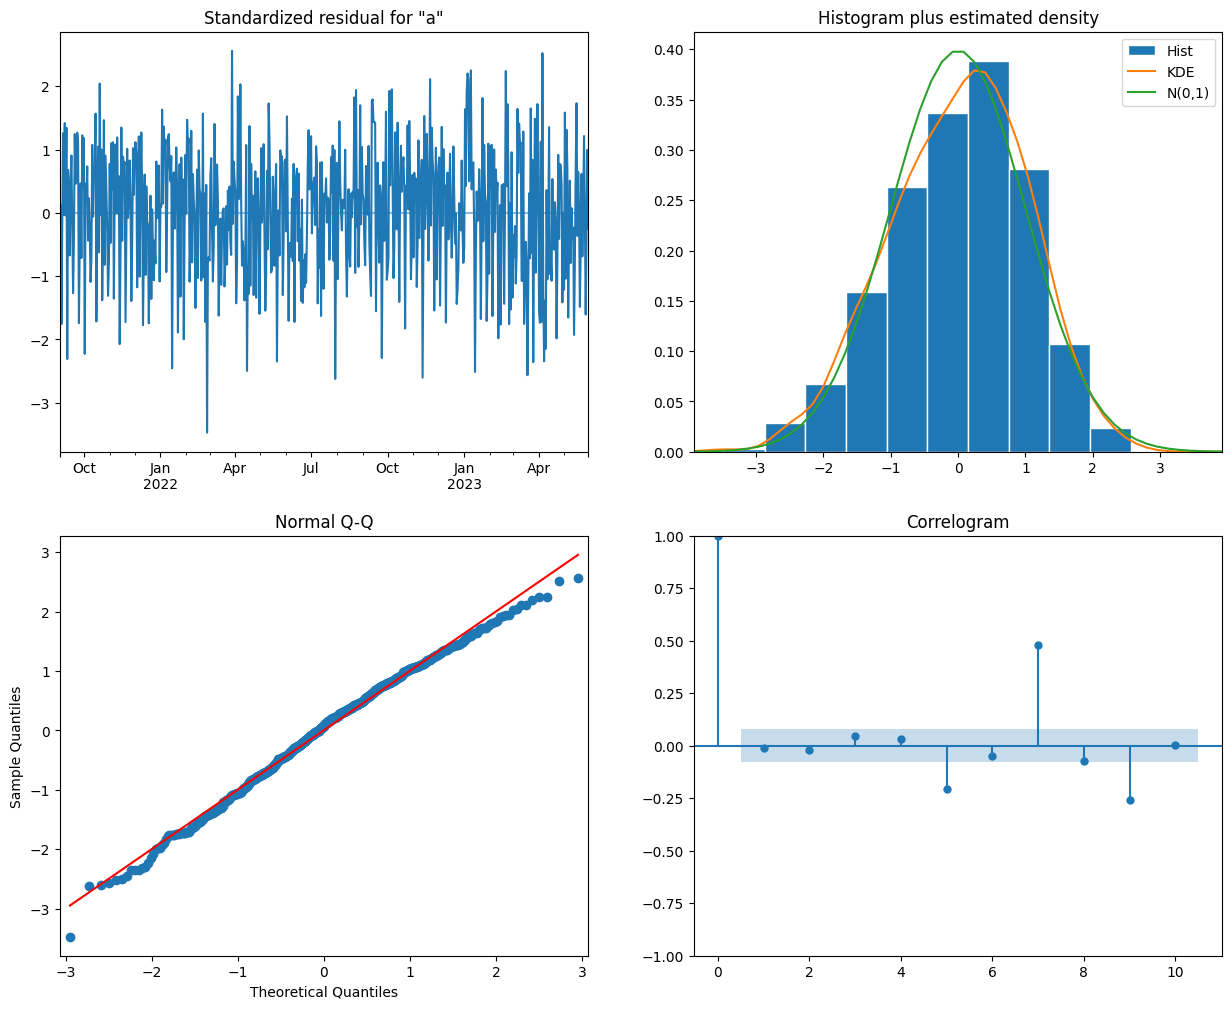

In [73]:
# Get predictions from the SARIMAX model
best_mod = sm.tsa.statespace.SARIMAX(train_new['agg_target'], exog=exog, order=(2,1,3),seasonal_order=(2, 0, 0, 10))

MSFTresults = best_mod.fit()

#print(TSresults.summary().tables[1])

MSFTresults.plot_diagnostics(figsize=(15, 12))
plt.show()

In [85]:
best_mod.

['agg_elec_price',
 'avg_gas_price',
 'ar.L1',
 'ar.L2',
 'ma.L1',
 'ma.L2',
 'ma.L3',
 'ar.S.L10',
 'ar.S.L20',
 'sigma2']

In [78]:
pred = MSFTresults.get_prediction(start=510, dynamic=False)

In [79]:
test_set

datetime
2023-01-24    731.864156
2023-01-25    707.557516
2023-01-26    701.433879
2023-01-27    668.479101
2023-01-28    552.802609
                 ...    
2023-05-27    270.002458
2023-05-28    266.600367
2023-05-29    386.553701
2023-05-30    409.555366
2023-05-31    392.622474
Name: agg_target, Length: 128, dtype: float64

In [83]:
mae = mean_absolute_error(test_set[:-1], pred.predicted_mean)
print(f"Mean Absolute Error (MAE): {mae}")
mape = mean_absolute_percentage_error(test_set[:-1], pred.predicted_mean)
print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")

Mean Absolute Error (MAE): 49.56396210680263
Mean Absolute Percentage Error (MAPE): 10.25%
